##### Import libary

In [2]:
import kaos
import numpy as np
import pandas as pd
from Bio import SeqIO
import time
import rpy2.robjects as robjects
from rpy2.robjects.packages import importr
import matplotlib.pyplot as plt

##### Define object

In [4]:
kaosr = importr('kaos')
seqinr = importr('seqinr')

##### fasta file path

In [5]:
file_path_ecoli = "GCF_000005845.2_ASM584v2_genomic.fna"

In [6]:
def return_r_character_array(python_string):

    """
    Convert a Python string to an R character array.

    Parameters:
    python_string (str): The input Python string to be converted.

    Returns:
    r_char_array (rpy2.robjects.vectors.StrVector): An R character array containing the characters from the input string.
    """
    
    import rpy2.robjects as robjects

    r_char_array = robjects.StrVector(list(python_string))

    return r_char_array

##### Read fasta

In [7]:
python_sequence_ecoli =    kaos.read_fasta(file_path_ecoli)
r_sequence  = return_r_character_array(python_sequence_ecoli)

In [8]:
def kaos_r(r_fasta_seq, k):

    start_time = time.time()
    x_cgr = kaosr.cgr(r_fasta_seq, res=k)
    end_time = time.time()

    return np.array(x_cgr.rx2('matrix')), (end_time - start_time)

In [9]:
def kaos_python(python_fasta_seq, kmer_length):
      
    chaos_game_kmer_array = kaos.chaos_game_representation_key(kmer_length=kmer_length)
        
    start_time = time.time()
    
    fcgr_matrix = kaos.chaos_frequency_matrix(fasta_string = python_fasta_seq, kmer_length= kmer_length, chaos_game_kmer_array= chaos_game_kmer_array, pseudo_count= False)[0]

    end_time = time.time()
    
    # print("Time taken: " + str(end_time - start_time))
    
    return fcgr_matrix, (end_time - start_time)
    

##### block to obtain correlation and time consumed

In [10]:
time_python = list()
time_r = list()
# corr_r = list()
corr_list = list()

python_fcgr = list()
r_fcgr = list()

for i in [1,2,3,4,5, 6,7,8,9, 10]:
# for i in [1,2]:

    fcgr_ecoli, python_time = kaos_python(python_sequence_ecoli, kmer_length = i)
    python_fcgr.append(fcgr_ecoli)
    
    r_fcgr_ecoli, r_time = kaos_r(r_sequence, k =2**i)
    r_fcgr.append(r_fcgr_ecoli)
    time_python.append(python_time)
    time_r.append(r_time)
    print("Current kmer length is ", str(i))
    print(r_fcgr_ecoli.shape, fcgr_ecoli.shape)
    print("The correlation coefficient for ecoli is ",    str(np.round(pd.Series(r_fcgr_ecoli.ravel()).corr(pd.Series(fcgr_ecoli.ravel())),3)))
    corr_list.append(np.round(pd.Series(r_fcgr_ecoli.ravel()).corr(pd.Series(fcgr_ecoli.ravel())),3))
    print("_______")
    # break
    del fcgr_ecoli, r_fcgr_ecoli, r_time, python_time



Current kmer length is  1
(2, 2) (2, 2)
The correlation coefficient for ecoli is  1.0
_______
Current kmer length is  2
(4, 4) (4, 4)
The correlation coefficient for ecoli is  0.377
_______
Current kmer length is  3
(8, 8) (8, 8)
The correlation coefficient for ecoli is  0.27
_______
Current kmer length is  4
(16, 16) (16, 16)
The correlation coefficient for ecoli is  0.258
_______
Current kmer length is  5
(32, 32) (32, 32)
The correlation coefficient for ecoli is  0.234
_______
Current kmer length is  6
(64, 64) (64, 64)
The correlation coefficient for ecoli is  0.226
_______
Current kmer length is  7
(128, 128) (128, 128)
The correlation coefficient for ecoli is  0.217
_______
Current kmer length is  8
(256, 256) (256, 256)
The correlation coefficient for ecoli is  0.203
_______
Current kmer length is  9
(512, 512) (512, 512)
The correlation coefficient for ecoli is  0.181
_______
Current kmer length is  10
(1024, 1024) (1024, 1024)
The correlation coefficient for ecoli is  0.146
__

##### MAE/ unique kmer

In [101]:
result = pd.DataFrame(columns=["kmer length", "mean absolue error"])

for i in range(10):

    print("kmer_length: ", i+1)
    print("The mar error  is : ", (np.abs(r_fcgr[i].ravel() - python_fcgr[i].ravel()).sum())/r_fcgr[i].ravel().shape)

    result.loc[i, "kmer length"] = i+1
    result.loc[i, "mean absolue error"] = np.mean(np.abs(r_fcgr[i].ravel() - python_fcgr[i].ravel()))
    result.loc[i, "std absolue error"] = np.std(np.abs(r_fcgr[i].ravel() - python_fcgr[i].ravel()))

kmer_length:  1
The mar error  is :  [0.]
kmer_length:  2
The mar error  is :  [41385.8125]
kmer_length:  3
The mar error  is :  [16334.96875]
kmer_length:  4
The mar error  is :  [6067.64453125]
kmer_length:  5
The mar error  is :  [2020.99414062]
kmer_length:  6
The mar error  is :  [605.05053711]
kmer_length:  7
The mar error  is :  [174.53198242]
kmer_length:  8
The mar error  is :  [49.50117493]
kmer_length:  9
The mar error  is :  [14.12918854]
kmer_length:  10
The mar error  is :  [4.25091839]


In [102]:
result

,kmer length,mean absolue error,std absolue error
0,1,0.0,0.000000
1,2,41385.8125,32140.490768
2,3,16334.96875,17451.619332
3,4,6067.644531,5680.667255
4,5,2020.994141,1739.250944
5,6,605.050537,534.318442
6,7,174.531982,161.163448
7,8,49.501175,48.304956
8,9,14.129189,14.733975
9,10,4.250918,4.727380


##### Dataframe containing time taken

In [103]:
df = pd.DataFrame(columns=["kaos", "SOTA"])
df["kmer length"] = range(1, 11)
df["kaos"] = time_python
df["SOTA"] = time_r
df

,kaos,SOTA,kmer length
0,0.635471,101.145446,1
1,0.784296,101.970002,2
2,0.811567,99.793320,3
3,0.836585,99.419668,4
4,0.853666,99.733879,5
5,0.869586,99.713875,6
6,1.001354,102.834933,7
7,1.337749,99.444069,8
8,2.243227,108.132066,9
9,3.208488,99.024960,10


In [104]:
rounded_df = df.applymap(lambda x: round(x, 3))
rounded_df

/tmp/ipykernel_117821/3777255039.py:1: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  rounded_df = df.applymap(lambda x: round(x, 3))


,kaos,SOTA,kmer length
0,0.635,101.145,1
1,0.784,101.970,2
2,0.812,99.793,3
3,0.837,99.420,4
4,0.854,99.734,5
5,0.870,99.714,6
6,1.001,102.835,7
7,1.338,99.444,8
8,2.243,108.132,9
9,3.208,99.025,10


In [105]:
def custom_figure_axis(ax, fontsize=10, show_ticks = True):

    """
    Customize the appearance of matplotlib axis for a figure.

    Parameters:
        ax (matplotlib.axes._subplots.AxesSubplot): The axis to be customized.
        fontsize (int, optional): Font size for axis labels and ticks. Default is 10.
        show_ticks (bool, optional): Whether to display ticks and labels. Default is True.

    Returns:
        matplotlib.axes._subplots.AxesSubplot: The customized axis.
    """

    ax.spines['bottom'].set_color('black')
    ax.spines['left'].set_color('black')
    ax.spines['top'].set_color('white')
    ax.spines['right'].set_color('white')
    ax.grid(False)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_linewidth(0.2)
    ax.spines['left'].set_linewidth(0.2)
    ax.tick_params(axis='x', labelsize=fontsize, rotation=0)
    ax.tick_params(axis='y', labelsize=fontsize)
    ax.tick_params(axis='both', which='both', width=0.5)
    ax.xaxis.label.set_fontsize(fontsize)
    ax.yaxis.label.set_fontsize(fontsize)
    
    if show_ticks==False:
        ax.set_xlabel(None)
        ax.set_ylabel(None)
        ax.set_xticklabels([])
        ax.set_yticklabels([])
        
    return ax

##### graph for time taken vs kmer length

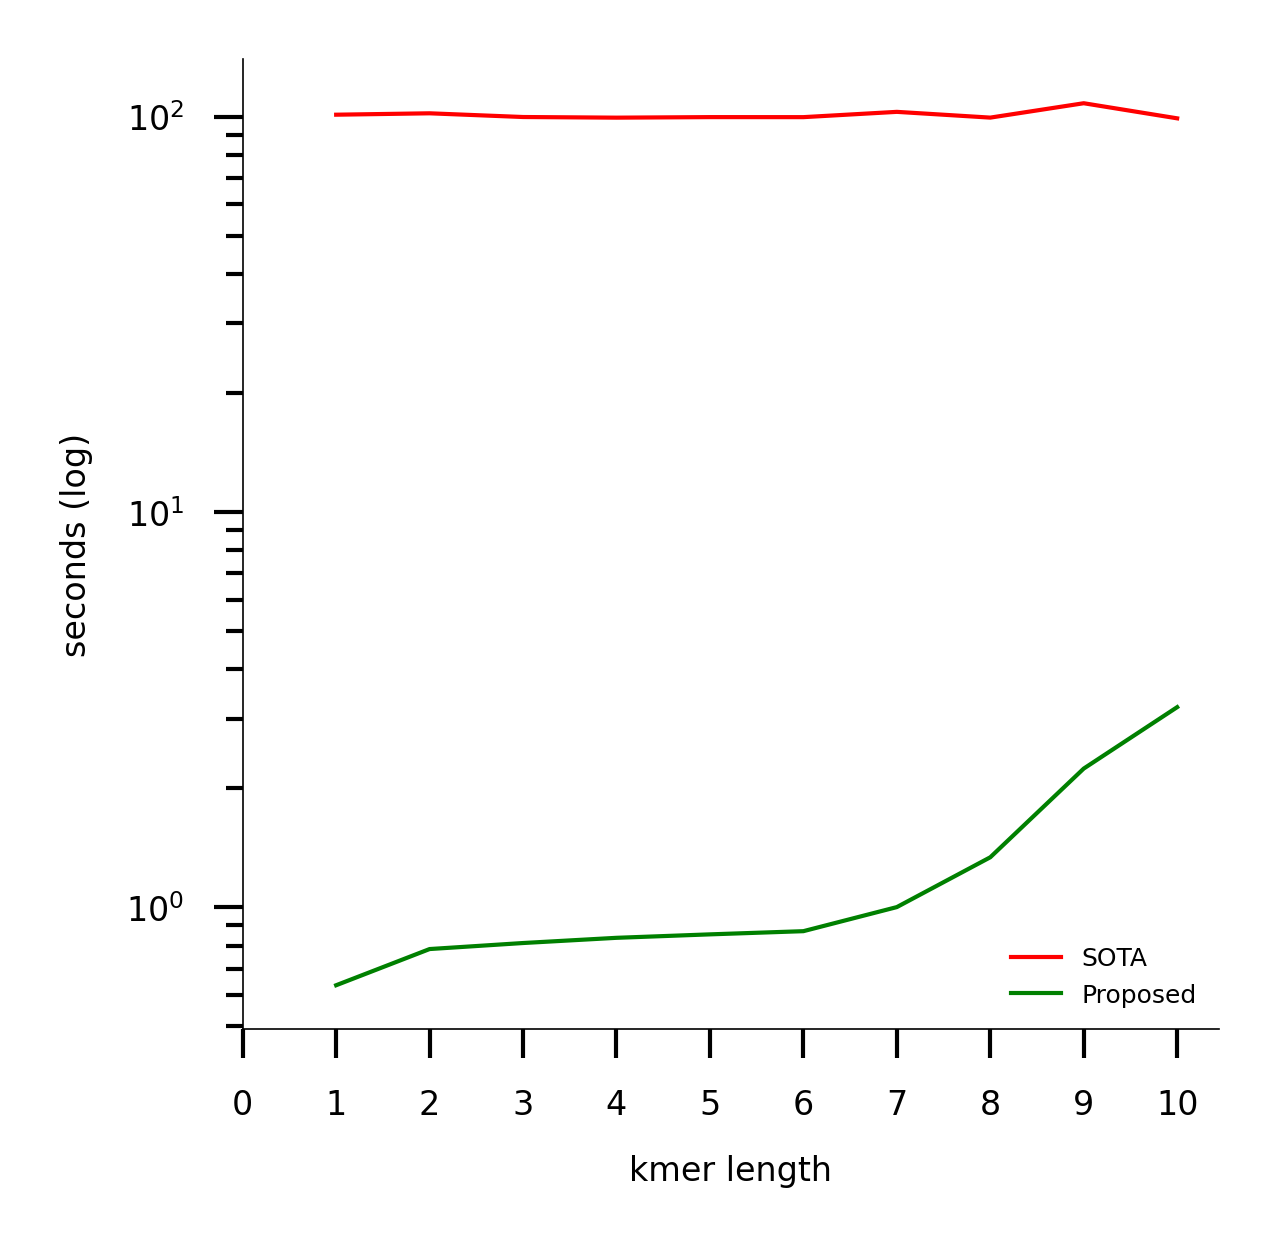

In [70]:
fig, ax = plt.subplots(1, 1, dpi = 600, figsize = (2.1, 2.1))

ax.plot(rounded_df["kmer length"], rounded_df["SOTA"], lw = 0.5, color = "red", label = "SOTA")
ax.plot(rounded_df["kmer length"], rounded_df["kaos"], lw = 0.5, color = "green", label = "Proposed")

ax.set_xlabel("kmer length")
ax.set_ylabel("seconds (log)")
ax = custom_figure_axis(ax, fontsize=4, show_ticks = True)
ax.legend(frameon=False, fontsize = 3)
ax.set_yscale('log')
ax.set_xticks([0, 1, 2, 3, 4, 5, 6, 7, 8 , 9, 10]);
plt.savefig("time.pdf", dpi = 600)

##### Bar plot for mean absolue error vs kmer length

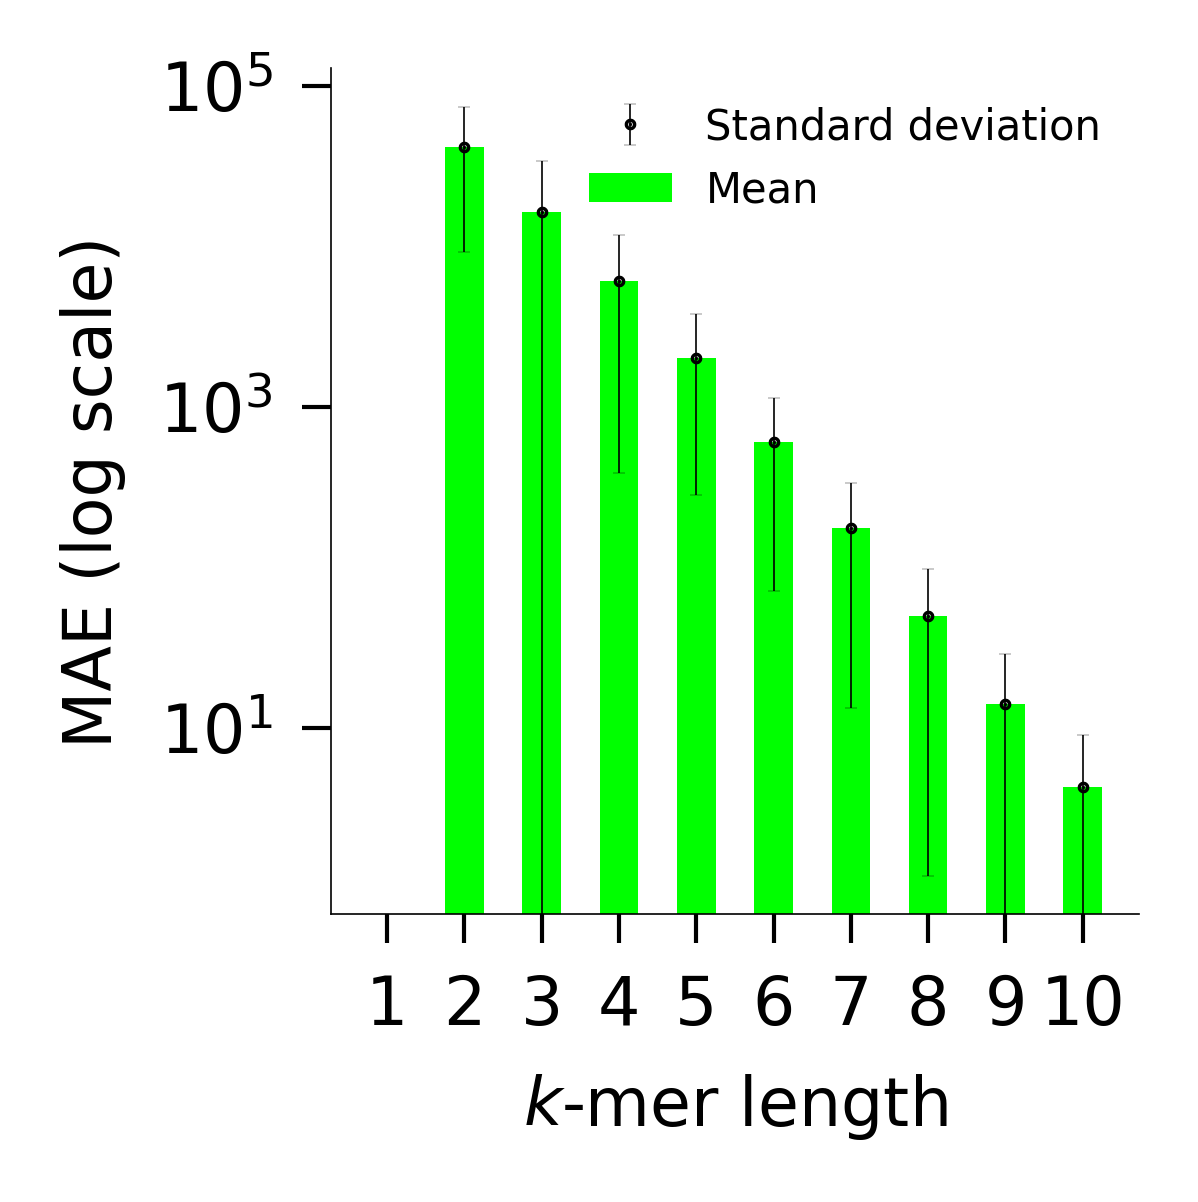

In [118]:
fig, ax = plt.subplots(1, 1, dpi = 600, figsize = (2.1, 2.1))
ax.errorbar(x = result["kmer length"], y = result["mean absolue error"], yerr=result["std absolue error"], fmt='o', capsize=0.75, label='Standard deviation', capthick=0.05, linewidth=0.2, color = "black", markersize=0.4)

# ax.plot(np.array(list(range(len(corr_list)))) + [1], time_r, lw = 0.5, color = "red", label = "time taken in R")
# ax.plot(np.array(list(range(len(corr_list)))) + [1], time_python, lw = 0.5, color = "green", label = "time taken in python")

ax.bar(result["kmer length"], result["mean absolue error"], label = "Mean", width = 0.5
       , color = "lime");

# ax.set_xlabel("kmer length")
ax.set_xlabel("$\mathit{k}$-mer length")
ax.set_ylabel("MAE (log scale)")
ax = custom_figure_axis(ax, fontsize=8, show_ticks = True)
ax.legend(frameon=False, fontsize = 5)
ax.set_yscale('log')
ax.set_xticks(list(result["kmer length"]))
plt.tight_layout()
plt.savefig("Mean absolute error.png", dpi = 600)